In [27]:
import os, pickle

from compound_db_utils import settings
from compound_db_utils.data_loaders import fetch_learning_data

data = None
if os.path.exists('data.pickle'):
    data = pickle.load(open('data.pickle', 'br'))
else:
    data = fetch_learning_data(
            ['MI-T-d480066c']
            , bioacitivities_cols=('activity_comment', 'value')
            , col_names_map={
                settings.COMPOUNDS_TABLE + '_smiles' : 'smiles'
                , settings.BIOACTIVITIES_TABLE + '_value' : 'ic50_experiment'
                , settings.BIOACTIVITIES_TABLE + '_activity_comment' : 'comment'
            }
            , create_rdkit_mols=False
            , compute_descriptors=True
        )
    
pickle.dump(data, open('data.pickle', 'bw'))    

In [28]:
from IPython.display import HTML
HTML(data[:5].to_html())

,comment,ic50_experiment,smiles,MinAbsEStateIndex,MaxPartialCharge,MinPartialCharge,MinEStateIndex,MolWt,MaxAbsPartialCharge,NumRadicalElectrons,ExactMolWt,MaxAbsEStateIndex,MaxEStateIndex,NumValenceElectrons,HeavyAtomMolWt,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Unspecified,274.0,COc1ccc(C2Sc3cc(O)ccc3OC2c2ccc(OCCN3CCCCC3)cc2)cc1,0.033404,0.140005,-0.507920,-0.168669,477.626,0.507920,0,477.197379,9.978540,9.978540,178,446.378,0.140005,1.326852,1080.565179,23.329852,19.482721,20.299218,16.691004,11.948567,12.828219,8.800899,9.984296,6.488031,7.834294,4.591978,5.916153,-2.83,8.733075e+07,22.937321,10.618123,5.286739,205.201164,19.317116,35.708896,0.000000,0.000000,0,0,4.899910,0.000000,0.000000,11.761885,30.686290,79.522629,6.544756,17.255219,19.317116,11.761885,0,4.899910,0,35.511853,33.350949,77.856941,0,22.998047,14.210589,0,22.998047,11.761885,43.357386,0.000000,0.000000,41.743272,71.625521,0,0.000000,0,51.16,0.000000,5.106527,0,17.103416,6.606882,39.815678,32.351978,31.004417,30.331835,29.165378,14.210589,0,1.711949,0,0,0,0,0,0,0.0000,67.454717,0.357143,34,1,5,0,2,2,3,0,3,6,1,6,7,0,1,1,5,6.23260,135.2958,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Unspecified,41.1,COc1ccc(C2Sc3cc(O)ccc3OC2c2ccc(OCCN3CCCCC3)cc2)cc1,0.033404,0.140005,-0.507920,-0.168669,477.626,0.507920,0,477.197379,9.978540,9.978540,178,446.378,0.140005,1.326852,1080.565179,23.329852,19.482721,20.299218,16.691004,11.948567,12.828219,8.800899,9.984296,6.488031,7.834294,4.591978,5.916153,-2.83,8.733075e+07,22.937321,10.618123,5.286739,205.201164,19.317116,35.708896,0.000000,0.000000,0,0,4.899910,0.000000,0.000000,11.761885,30.686290,79.522629,6.544756,17.255219,19.317116,11.761885,0,4.899910,0,35.511853,33.350949,77.856941,0,22.998047,14.210589,0,22.998047,11.761885,43.357386,0.000000,0.000000,4

In [29]:
sum(data.comment == 'Active')

219

In [30]:
sum(data.comment == 'Not Active')

81

In [31]:
data.shape

(1973, 199)

In [32]:
import numpy as np

data.ic50_experiment = data.ic50_experiment.apply(lambda x : -1.0 * np.log10(x / 1.0e9))

[]

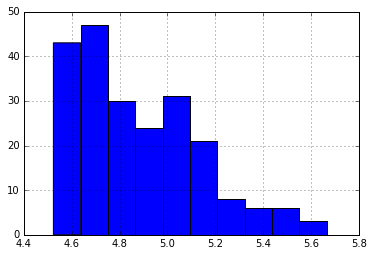

In [33]:
%matplotlib inline
data[data.comment == 'Active'].ic50_experiment.hist().plot()

[]

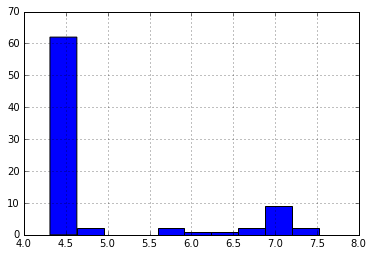

In [34]:
data[data.comment == 'Not Active'].ic50_experiment.hist().plot()

[]

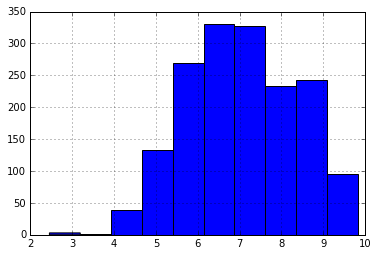

In [35]:
data[data.comment == 'Unspecified'].ic50_experiment.hist().plot()

In [49]:
from sklearn.feature_selection import VarianceThreshold

descriptors = data.iloc[:,3:]
descriptors_names = data.columns.values[3:]

def show_feat_sele_results(model, descriptors, descriptors_names):
    print(descriptors.shape)
    descriptors = descriptors.iloc[:,model.get_support()]
    descriptors_names = descriptors_names[model.get_support()]
    print(descriptors.shape)
    
    return descriptors, descriptors_names

var_sel = VarianceThreshold()
var_sel.fit(descriptors)

descriptors, descriptors_names = show_feat_sele_results(var_sel, descriptors, descriptors_names)

(1973, 196)
(1973, 171)


In [50]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

regre_sele = SelectPercentile(f_regression, percentile=50)
regre_sele.fit(descriptors, data.ic50_experiment)

descriptors, descriptors_names = show_feat_sele_results(regre_sele, descriptors, descriptors_names)

(1973, 171)
(1973, 85)


In [51]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

lasso = Lasso(
    normalize=False
    , fit_intercept=True
    , copy_X=True
    , random_state=42
    , max_iter=2e3
).fit(descriptors, data.ic50_experiment)
sel_from_mod = SelectFromModel(lasso, prefit=True)

descriptors, descriptors_names = show_feat_sele_results(sel_from_mod, descriptors, descriptors_names)

(1973, 85)
(1973, 8)


In [52]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=5)
pca.fit(descriptors)
pca_result = pca.transform(descriptors)
eigen_values = pca.explained_variance_ratio_

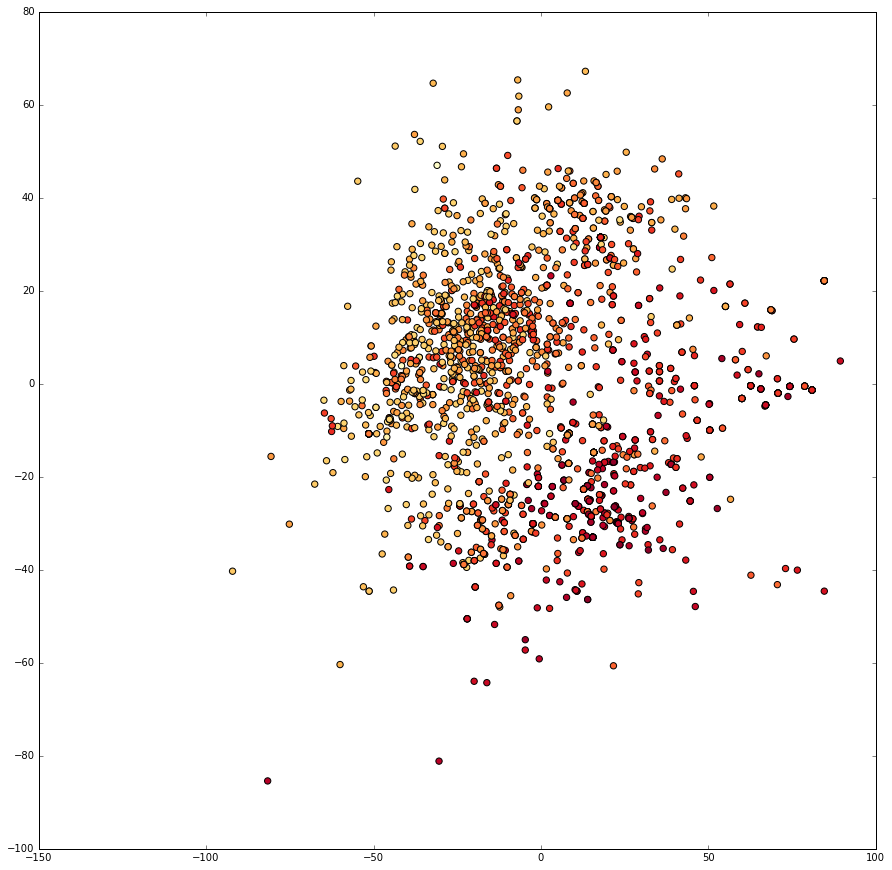

In [79]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 15]
plt.scatter(
    pca_result[:,0]
    , pca_result[:,1]
    , c=data.ic50_experiment
    , s=40
    , cmap='YlOrRd' # red are the compounds with higher values of pIC50
)
plt.show()

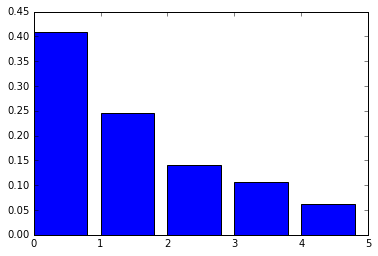

In [54]:
plt.bar(range(pca_result.shape[1]), eigen_values)
plt.show()